In [1]:
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from dataclasses import dataclass

from pydrake.all import (MathematicalProgram, Solve, MonomialBasis,
                         DiagramBuilder, Evaluate, LogVectorOutput, Simulator,
                         SymbolicVectorSystem, Variable, ToLatex, Polynomial,
                         VectorSystem, eq, ge, le, Formula, Expression, Evaluate,
                         LeafSystem, AbstractValue)

from dccm_quasistatic.utils.math_utils import (create_square_symmetric_matrix_from_lower_tri_array,
                                               get_n_lower_tri_from_matrix_dim,
                                               matrix_inverse)



## Sampled A and B matrices

In [2]:
prog = MathematicalProgram()
deg = 6
# Convergence rate = 1-beta
beta = 0.1
dim_x = 2
dim_u = 1
# Indeterminates
x = prog.NewIndeterminates(dim_x, 'x_{k}')
u = prog.NewIndeterminates(dim_u, 'u_{k}')
w = prog.NewIndeterminates(dim_x * 2, 'w')
w = np.array(w).reshape(-1, 1)

# Monomial basis
v = [monomial.ToExpression() for monomial in MonomialBasis(x, deg)]
dim_v = len(v)
n_lower_tri = get_n_lower_tri_from_matrix_dim(dim_x)
wijc = prog.NewContinuousVariables(rows=n_lower_tri, cols=dim_v, name='wijc')

lijc = prog.NewContinuousVariables(rows=dim_x * dim_u, cols=dim_v, name='lijc')

r = prog.NewContinuousVariables(1, 'r')

lb = -3
ub = 3
N = 100
x_samples = np.random.uniform(lb, ub, (N, 2))
u_samples = np.random.uniform(lb, ub, (N, 1))

for i in range(N):
    xi = x_samples[i, :]
    ui = u_samples[i, :]
    # A and B matrices
    Ak = np.array([[1.1-0.1*xi[1],   0],
                [0.1         ,   0.9]])
    Bk = np.array([1, 0])[:, np.newaxis]

    # Create mapping of variables to values
    env = dict(zip(x, xi))
    # Substitute xi into v(xi)
    v_xi = Evaluate(v, env).flatten()

    xi_next = [1.1*xi[0] - 0.1*xi[0]*xi[1] + ui[0],
               0.9*xi[1] + 0.9*xi[0]]
    # Create mapping of variables to values
    env = dict(zip(x, xi_next))
    # Substitute xi_next into v(xi_next)
    v_xi_next = Evaluate(v, env).flatten()

    Wk_lower_tri = wijc.dot(v_xi)
    Wk = create_square_symmetric_matrix_from_lower_tri_array(Wk_lower_tri)
    # print("W11k: ", W11k)

    Wk_next_lower_tri = wijc.dot(v_xi_next)
    Wk_next = create_square_symmetric_matrix_from_lower_tri_array(Wk_next_lower_tri)


    Lk_elements = lijc.dot(v_xi)
    Lk = Lk_elements.reshape(dim_u, dim_x)

    # print("Wk: ", Wk.shape)
    # print("Ak: ", Ak.shape)
    # print("Bk: ", Bk.shape)
    # print("Lk: ", Lk.shape)


    cross_diag = Ak @ Wk + Bk @ Lk
    omega = np.block([[Wk_next, cross_diag],
                    [cross_diag.T, (1-beta)*Wk]])
    # print("omega: ", omega.shape)
    # Note: w is an additional indeterminate that enforces that omega is PSD

    prog.AddSosConstraint((w.T @ omega @ w - r[0] * w.T @ w).flatten()[0])
    

prog.AddLinearCost(r[0])
prog.AddLinearConstraint(r[0] >= 0.01)



# Verify that the solution is meets constraints:
# prog.SetInitialGuess(w11c, w11c_ans)
# prog.SetInitialGuess(w12c, w12c_ans)
# prog.SetInitialGuess(w22c, w22c_ans)
# prog.SetInitialGuess(l1c, l1c_ans)
# prog.SetInitialGuess(l2c, l2c_ans)

result = Solve(prog)
print("Solver succeeded: ", result.is_success())

infeasible_constraints = result.GetInfeasibleConstraints(prog)
for c in infeasible_constraints:
    print(f"infeasible constraint: {c}")

# Extract the solution
print("wijc:\n", result.GetSolution(wijc))
print("\nlijc:\n", result.GetSolution(lijc))
print("r:\n", result.GetSolution(r))

wijc_ans = result.GetSolution(wijc)
lijc_ans = result.GetSolution(lijc)


Solver succeeded:  True
wijc:
 [[ 4.10645080e-05 -6.67944438e-05  1.52223278e-04 -1.93069857e-04
   1.54980188e-04 -6.47465932e-05  2.00692616e-05  7.92721935e-05
  -1.59708528e-04  2.82209261e-04 -2.95121454e-04  1.68814238e-04
  -1.79306375e-05 -1.39329543e-03  1.63379780e-03 -2.35463566e-03
   1.51198326e-03 -8.42049493e-04 -1.93110511e-03  2.57725336e-03
  -2.64975657e-03  4.08595693e-04  9.85499386e-03 -8.16365356e-03
   7.97615900e-03  1.01488197e-02 -1.86311294e-03  4.16251848e-01]
 [-4.27859547e-05  9.35717087e-05 -1.09471346e-04 -2.14779248e-06
   7.14068170e-05 -3.95813709e-05  2.64856464e-06  4.27008358e-05
  -2.22333410e-04  2.45196460e-04 -1.90895972e-04  6.92544993e-05
  -3.06252046e-05  1.27525277e-03 -1.65476630e-03  1.39004110e-03
  -4.22548101e-04  5.07797292e-05  6.51265105e-05  2.21441393e-03
  -6.48999183e-04  7.91301460e-04 -5.09774454e-03  8.16374883e-03
   1.38876324e-04 -7.57807102e-03 -4.74038165e-03 -9.84913994e-02]
 [ 1.79935510e-04 -4.49024716e-04 -4.663717

# Online Computation

In [3]:
def display_expression(label:str, expr):
    display(
        Markdown(
            f"${label} = "
            + ToLatex(
                Polynomial(expr)
                .RemoveTermsWithSmallCoefficients(1e-5)
                .ToExpression(),
                6,
            )
            + "$"
        )
    )

In [4]:
class DesiredTrajectorySource(LeafSystem):
    def __init__(self, dim_x, dim_u):
        LeafSystem.__init__(self)
        self.dim_x = dim_x
        self.dim_u = dim_u
        self.DeclareVectorOutputPort("x_desired", dim_x, self.CalcXDesired)
        self.DeclareVectorOutputPort("u_desired", dim_u, self.CalcUDesired)
    
    def CalcXDesired(self, context, output):
        t = context.get_time()
        if t < 3.3:
            xd = 0
        elif t < 6.6:
            xd = 1
        else:
            xd = 0.5
        # xd = 0
        
        output.SetFromVector(np.ones(self.dim_x) * xd)
    
    def CalcUDesired(self, context, output):
        ud = 0
        output.SetFromVector(np.ones(self.dim_u) * ud)

In [5]:
@dataclass
class DCCMOnlineParams:
    """
    Parameters for the DCCM controller to run online.
    """
    wijc: np.ndarray
    lijc: np.ndarray

    # System parameters
    dim_x: int = 2 # Dimension of the state
    dim_u: int = 1 # Dimension of the input

    # DCCM Params
    deg: int = 6 # Degree of the polynomial

    # Geodesic calculation parameters
    N: int = 5 # Number of segments to discretize the geodesic into
    
    
class DCCMOnlineController(LeafSystem):
    def __init__(self, params: DCCMOnlineParams):
        LeafSystem.__init__(self)
        self.params = params

        self._geodesic_index = self.DeclareAbstractState(
            AbstractValue.Make(0.0)
        )

        # Inputs
        self._xk_index = self.DeclareVectorInputPort("x_current", self.params.dim_x).get_index()
        self._xd_index = self.DeclareVectorInputPort("x_desired", self.params.dim_x).get_index()
        self._ud_index = self.DeclareVectorInputPort("u_desired", self.params.dim_u).get_index()

        # Outputs
        self.DeclareVectorOutputPort("u_current", self.params.dim_u, self.DoCalcOutput)
        self.DeclareVectorOutputPort("geodesic_current", 1, self.RetrieveGeodesicLength)
    
    def RetrieveGeodesicLength(self, context, output):
        geodesic = context.get_abstract_state(int(self._geodesic_index)).get_value()
        output.SetFromVector([geodesic])
    
    def DoCalcOutput(self, context, output):

        # unpack inputs
        xk = self.get_input_port(self._xk_index).Eval(context)
        xd = self.get_input_port(self._xd_index).Eval(context)
        ud = self.get_input_port(self._ud_index).Eval(context)

        t = context.get_time()
        u, geodesic = self.control_law(xk, xd, ud, t)
        context.get_mutable_abstract_state(int(self._geodesic_index)).set_value(geodesic)
        output.SetFromVector(u)
        
    def control_law(self, xk: np.array, xd: np.array, ud: np.array, t: float = 0) -> np.array:
        # return [1]
        # print(f"t: {t}, xk = {xk}, xd = {xd}, ud = {ud}")
        succeeded, xi, delta_xs, delta_s, geodesic = self.calculate_geodesic(xk, xd)
        if not succeeded:
            print(f"Geodesic calculation failed at time: {t}, u = {ud}")
            return ud, geodesic
    
        x = [Variable(f"x_{i}") for i in range(self.params.dim_x)]
        v = [monomial.ToExpression() for monomial in MonomialBasis(x, deg)] # might need to wrap x in Variables()

        # Probably need to set this u* to something else!
        u = ud
        for i in range(self.params.N):
            # Create mapping of variables to values
            env = dict(zip(x, xi[i]))
            # Substitute xi into v(xi)
            v_xi = Evaluate(v, env).flatten()
            # Construct L(xi)
            Li_elements = self.params.lijc.dot(v_xi)
            Li = Li_elements.reshape(self.params.dim_u, self.params.dim_x)
            # Construct W(xi)
            Wi_lower_tri = self.params.wijc.dot(v_xi)
            # print(f"Wk_lower_tri.shape: {Wk_lower_tri.shape}")

            Wi = create_square_symmetric_matrix_from_lower_tri_array(Wi_lower_tri)
            # Get M(xi) by inverting W(xi)
            Mi = np.linalg.inv(Wi)
            # Add marginal control input to u
            u = u - delta_s[i] * Li @ Mi @ delta_xs[i]
        
        print(f"Geodesic calculation succeeded at time: {t}, u = {u}")

        return u, geodesic

    def calculate_geodesic(self, x0, x1):
        """
        Calculate the geodesic from x0 to x1.
        Based on optimization (27)
        Args:
            x0: (dim_x,): initial state, will correspond to x_k
            x1: (dim_x,): final state, will correspond to x*_k
        """
        prog = MathematicalProgram()
        
        # Numerical state evaluation along the geodesic
        x = prog.NewContinuousVariables(self.params.N + 1, self.params.dim_x, 'x')

        # For optimizing over the epigraph instead of the original objective
        y = prog.NewContinuousVariables(self.params.N, 'y')

        # Displacement vector discretized wrt s parameter
        delta_xs = prog.NewContinuousVariables(self.params.N, self.params.dim_x, '\delta x_s')
        
        # Small positive scaler value
        delta_s = prog.NewContinuousVariables(self.params.N, 's')

        # Add constraint: make sure delta_s's are positive
        si_positive = prog.AddLinearConstraint(ge(delta_s, np.ones_like(delta_s) * 1e-6))

        # Add constraints
        # Constraint 1
        si_sum_to_one = prog.AddLinearConstraint(sum(delta_s) == 1)

        discrete_distances_sum = x0
        # Constraint: Initial state matches x0
        prog.AddConstraint(eq(x[0], x0))
        for i in range(self.params.N):
            discrete_distances_sum = discrete_distances_sum + delta_s[i] * delta_xs[i]
            # Constraint 2: Intermediate state matches sum of deltas

            prog.AddConstraint(eq(x[i+1], discrete_distances_sum))
        # Constraint 3
        total_distances_match = prog.AddConstraint(eq(discrete_distances_sum, x1))
    
        # Sum cost over all segments
        prog.AddCost(np.sum(y))
        # Constraints for the values of y
        for i in range(self.params.N):
            v = [monomial.ToExpression() for monomial in MonomialBasis(x[i], deg)]
            # Construct W(x_i)
            Wk_lower_tri = self.params.wijc.dot(v)
            Wi = create_square_symmetric_matrix_from_lower_tri_array(Wk_lower_tri)
            # Get M(x_i) by inverting W(x_i)
            Mi = matrix_inverse(Wi) # self.get_2x2_inverse(Wi) # <= because of the division, this is not a polynomial anymore.
            
            # Rational Polynomial Expression
            metric_dist = delta_s[i] * delta_xs[i].T @ Mi @ delta_xs[i]
            # print(f"metric_dist: {metric_dist}")
            # print(f"metric_dist.is_polynomial(): {metric_dist.is_polynomial()}")
            # print(f"metric_dist type: {type(metric_dist)}")
            prog.AddConstraint(metric_dist <= y[i])
        
        # Try to keep delta_s small
        prog.AddCost(np.sum(delta_s**2))

        # Seed initial guess as all 1's so that determinant will not be 0 and cause a failure
        prog.SetInitialGuessForAllVariables(np.ones(prog.num_vars()))

        result = Solve(prog)
        geodesic_length = np.sum(result.GetSolution(y))
        return result.is_success(), result.GetSolution(x), result.GetSolution(delta_xs), result.GetSolution(delta_s), geodesic_length
    
    def get_2x2_inverse(self, A: np.array) -> np.array:
        # This doesn't work: np.linalg.inv(A)
        det = A[0, 0] * A[1, 1] - A[0, 1] * A[1, 0]
        return np.array([[A[1, 1], -A[0, 1]], [-A[1, 0], A[0, 0]]]) / det
         
def test_control_law():
    # Test the control law
    x0 = np.array([1, 0.5])
    x1 = np.array([0, 0])
    ud = np.array([0])
    params = DCCMOnlineParams(wijc_ans, lijc_ans,
                              N=10)
    controller = DCCMOnlineController(params)
    res = controller.control_law(x0, x1, ud)
    print("res: ", res)

def test_geodesic():
    # Test the geodesic calculation
    x0 = np.array([1, 0.5])
    x1 = np.array([0, 0])
    ud = np.array([0])
    params = DCCMOnlineParams(wijc_ans, lijc_ans,
                              N=10)
    controller = DCCMOnlineController(params)
    succeeded, x, delta_xs, delta_s, geodesic = controller.calculate_geodesic(x0, x1)
    print("succeeded: ", succeeded)
    print("x: ", x)
    print("delta_xs: ", delta_xs)
    print("delta_s: ", delta_s)

    visualize_geodesic_path(x0, x1, x, delta_xs, delta_s)

def visualize_geodesic_path(x0, x1, x, delta_xs, delta_s):
    """
    Visualize the geodesic path from x0 to x1.
    """

    plt.plot(x[:, 0], x[:, 1], 'o-')
    plt.plot(x0[0], x0[1], 'o', color='red')
    plt.plot(x1[0], x1[1], 'o', color='green')
    plt.show()

# test_geodesic()
test_control_law()

Geodesic calculation succeeded at time: 0, u = [-1.20042443]
res:  (array([-1.20042443]), 0.3942139573680976)


$x_{1_{k+1}} = (1.100000x_{1_k} + u_k - 0.100000x_{1_k} x_{2_k})$

$x_{2_{k+1}} = (0.100000x_{1_k} + 0.900000x_{2_k})$

Geodesic calculation succeeded at time: 0.0, u = [-1.19950511]
Geodesic calculation succeeded at time: 0.1, u = [0.00572523]
Geodesic calculation succeeded at time: 0.2, u = [0.02676426]
Geodesic calculation succeeded at time: 0.30000000000000004, u = [0.02466037]
Geodesic calculation succeeded at time: 0.4, u = [0.02216231]
Geodesic calculation succeeded at time: 0.5, u = [0.01980197]
Geodesic calculation succeeded at time: 0.6000000000000001, u = [0.01761479]
Geodesic calculation succeeded at time: 0.7000000000000001, u = [0.01561132]
Geodesic calculation succeeded at time: 0.8, u = [0.0137927]
Geodesic calculation succeeded at time: 0.9, u = [0.01215404]
Geodesic calculation succeeded at time: 1.0, u = [0.01068636]
Geodesic calculation succeeded at time: 1.1, u = [0.00937832]
Geodesic calculation succeeded at time: 1.2000000000000002, u = [0.00821733]
Geodesic calculation succeeded at time: 1.3, u = [0.00719033]
Geodesic calculation succeeded at time: 1.4000000000000001, u = [0.0062

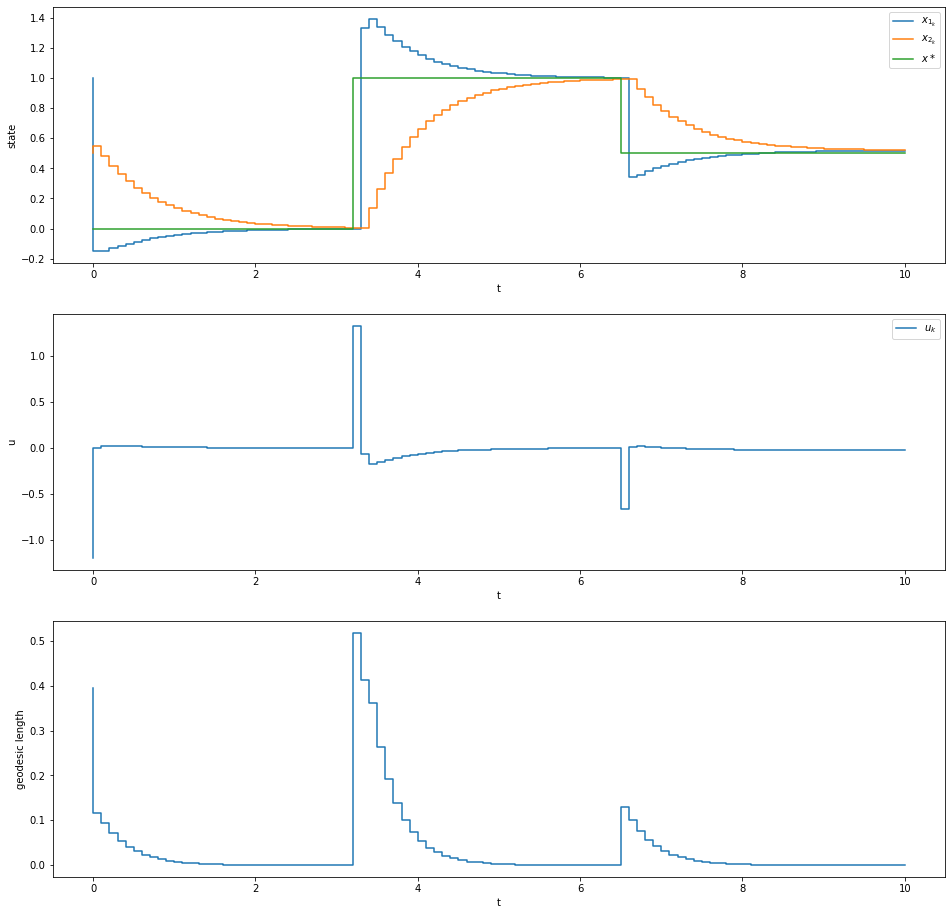

In [6]:
params = DCCMOnlineParams(wijc_ans, lijc_ans,
                          deg=deg, N=3)
x1 = Variable('x_{1_k}')
x2 = Variable('x_{2_k}')
u = np.array([Variable('u_k')])
x = np.array([x1, x2])

# A and B matrices
Ak = np.array([[1.1-0.1*x[1],   0],
               [0.1         ,   0.9]])
Bk = np.array([1, 0])[:, np.newaxis]


dynamics= Ak @ x + Bk @ u
display_expression('x_{1_{k+1}}', dynamics[0])
display_expression('x_{2_{k+1}}', dynamics[1])

cstr_sys = SymbolicVectorSystem(state=x,
                           dynamics=dynamics,
                           input=u,
                           output=x,
                           time_period=0.1 # Discrete time system
                           )

builder = DiagramBuilder()
system = builder.AddSystem(cstr_sys)

# DCCM Controller
controller = builder.AddSystem(DCCMOnlineController(params))

# Desired trajectory system
desired_trajectory = builder.AddSystem(DesiredTrajectorySource(params.dim_x, params.dim_u))

builder.Connect(desired_trajectory.GetOutputPort("x_desired"), controller.GetInputPort("x_desired"))
builder.Connect(desired_trajectory.GetOutputPort("u_desired"), controller.GetInputPort("u_desired"))
builder.Connect(system.get_output_port(0), controller.GetInputPort("x_current"))
builder.Connect(controller.GetOutputPort("u_current"), system.get_input_port(0))
# builder.ExportInput(system.get_input_port(0))

# Loggers
x_logger = LogVectorOutput(system.get_output_port(0), builder)
xd_logger = LogVectorOutput(desired_trajectory.GetOutputPort("x_desired"), builder)
u_logger = LogVectorOutput(controller.GetOutputPort("u_current"), builder)
g_logger = LogVectorOutput(controller.GetOutputPort("geodesic_current"), builder)

diagram = builder.Build()

context = diagram.CreateDefaultContext()
context.SetDiscreteState([1, 0.5])

# system_context = diagram.GetMutableSubsystemContext(system, context)
# system.get_input_port(0).FixValue(system_context, [0])

simulator = Simulator(diagram, context)
simulator.AdvanceTo(10)

# Plot the results.
x_log = x_logger.FindLog(context)
xd_log = xd_logger.FindLog(context)
u_log = u_logger.FindLog(context)
g_log = g_logger.FindLog(context)

fig, axs = plt.subplots(3, 1, figsize=(16, 16))

axis = axs[0]
axis.step(x_log.sample_times(),
         x_log.data().transpose(),
         x_log.sample_times(), xd_log.data().transpose()[:,0])
axis.legend([r'$x_{1_k}$', r'$x_{2_k}$', r'$x*$'])
axis.set_ylabel('state')
axis.set_xlabel('t')

axis = axs[1]
axis.step(u_log.sample_times(),
         u_log.data().transpose())
axis.legend([r'$u_{k}$'])
axis.set_ylabel('u')
axis.set_xlabel('t')

axis = axs[2]
axis.step(g_log.sample_times(),
         g_log.data().transpose())
axis.set_ylabel('geodesic length')
axis.set_xlabel('t')

plt.show()